In [1]:
%load_ext autoreload
%autoreload 2
import os
import time
import pickle
import numpy as np
import pandas as pd
import multiprocess as mp
from IPython.display import HTML, SVG

from pydrake.geometry import MeshcatVisualizerCpp, MeshcatVisualizerParams, Role, StartMeshcat
from pydrake.geometry.optimization import IrisInConfigurationSpace, IrisOptions
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
# from pydrake.planning.common_robotics_utilities import SimpleRRTPlannerState
from pydrake.solvers.gurobi import GurobiSolver
from pydrake.solvers.mosek import MosekSolver
from pydrake.systems.framework import DiagramBuilder

from gcs.linear import LinearGCS
from gcs.rounding import randomForwardPathSearch
from reproduction.prm_comparison.planning import PRM, BiRRT
from reproduction.prm_comparison.helpers import (
    ForwardKinematics,
    get_traj_length,
    InverseKinematics,
    is_traj_confined,
    make_traj,
    visualize_trajectory,
)
from reproduction.util import *

os.environ["MOSEKLM_LICENSE_FILE"] = "/Users/varun/mosek/mosek.lic"
GurobiSolver.AcquireLicense()
MosekSolver.AcquireLicense()


In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [3]:
SEED = 17
np.random.seed(SEED)

In [4]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
parser = Parser(plant)
parser.package_map().Add("gcs", GcsDir())

directives_file = FindModelFile("models/prm_comparison_moved_bins_yaml.yaml")
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
[iiwa, wsg, binR, binL, table] =  models
 

plant.Finalize()

meshcat_params = MeshcatVisualizerParams()
meshcat_params.delete_on_initialization_event = False
meshcat_params.role = Role.kIllustration
# meshcat_params.role = Role.kProximity
meshcat_cpp = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat, meshcat_params)

diagram = builder.Build()

context = diagram.CreateDefaultContext()
#plant_context = plant.GetMyContextFromRoot(context)
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
plant.SetPositions(plant_context, q0)
diagram.Publish(context)

/var/folders/p0/l4__0wtd3j184sv9zspd0qlm0000gn/T/ipykernel_29917/540500919.py:18: DrakeDeprecationWarning: MeshcatVisualizerCpp has been renamed to MeshcatVisualizer. The deprecated code will be removed from Drake on or after 2022-11-01.
  meshcat_cpp = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat, meshcat_params)


# Generate Iris Regions
### via manual seeds

In [5]:
milestones =  {"Above Bins": [[0.75, 0, 0.9],    [0, -np.pi, -np.pi/2]],   
                "Left Bin":    [[0.4,  0.4, 0.22], [np.pi/2, np.pi, 0]], 
                "Right Bin":   [[0.4, -0.4, 0.22], [np.pi/2, np.pi, np.pi]]}

additional_seed_points = {"Left to Bins": np.array([0.8, 0.7, 0, -1.6, 0, 0, np.pi/2]),
                          "Right to Bins":np.array([-0.8, 0.7, 0, -1.6, 0, 0, np.pi/2])} 

q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
milestone_configurations =  {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in milestones.items()}

seed_points = {**milestone_configurations, **additional_seed_points}

In [6]:
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 10
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.01
iris_options.enable_ibex = False
CORE_CNT = mp.cpu_count() # you may edit this

In [7]:
def calcRegion(seed, verbose):
    start_time = time.time()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    plant.SetPositions(plant_context, seed)
    hpoly = IrisInConfigurationSpace(plant, plant_context, iris_options)
    print("Seed:", seed, "\tTime:", time.time() - start_time, flush=True)
    return hpoly

def generateRegions(seed_points, verbose = True):
    seeds = list(seed_points.values()) if type(seed_points) is dict else seed_points
    regions = []
    loop_time = time.time()
    # with mp.Pool(processes = CORE_CNT) as pool:
    #     regions = pool.starmap(calcRegion, [[seed, verbose] for seed in seeds])
    regions = [calcRegion(seed, verbose) for seed in seeds] # Non-parallel version
    
    if verbose:
        print("Loop time:", time.time() - loop_time)
    
    if type(seed_points) is dict:
        return dict(list(zip(seed_points.keys(), regions)))
    
    return regions
pass



In [8]:
regions = generateRegions(seed_points)

Seed: [ 6.41950821e-05  4.71953264e-01 -1.49318242e-04 -6.71673454e-01
  1.85368193e-04  4.26169599e-01  1.57069215e+00] 	Time: 83.195148229599
Seed: [ 0.52648771  0.72566084  0.37083279 -1.61082971 -0.32151931  0.86560013
  1.02302474] 	Time: 24.8166561126709
Seed: [-0.52625678  0.72572069 -0.3711727  -1.6108296   0.32181951  0.86565552
  2.11835032] 	Time: 13.881561040878296
Seed: [ 0.8         0.7         0.         -1.6         0.          0.
  1.57079633] 	Time: 0.010614871978759766
Seed: [-0.8         0.7         0.         -1.6         0.          0.
  1.57079633] 	Time: 0.005000114440917969
Loop time: 121.94297981262207


## via pre-generated regions

In [9]:
# #load regions
# with open(os.path.join(GcsDir(), "data/prm_comparison/IRIS.reg"), "rb") as f:
#     regions = pickle.load(f)

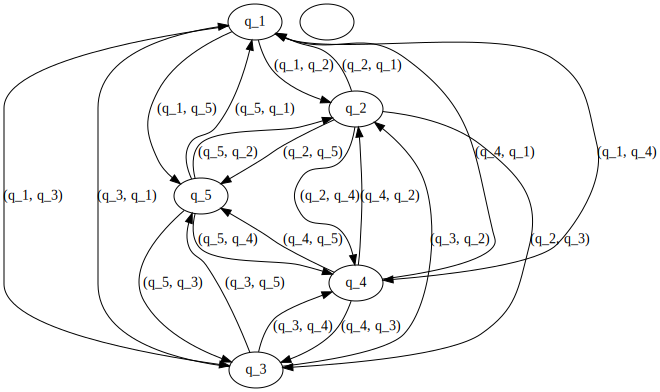

In [10]:
gcs = LinearGCS({f"q_{i + 1}":r for i, r in enumerate(regions.values())})
SVG(gcs.VisualizeGraph()) 

# Build PRM

In [11]:
# collision_step_size = 0.02
# K = 5
# roadmap_size = 15000

# #initlize with seeds for fairness
# prm = PRM(plant, diagram, collision_step_size, SEED, K, list(seed_points.values()))

### Load Roadmap if you don't want to wait 15 minutes

In [12]:
# #TODO use wget here to download th prm map from server
# prm.load(os.path.join(GcsDir(), "data/prm_comparison/15k_presplined.rmp"))

### Or Grow it 

In [13]:
# solve_timeout = 200
# goal_bias = 0.05
# step_size = 0.1
# birrt = BiRRT(plant, diagram, collision_step_size, SEED, step_size, goal_bias, solve_timeout)

### Connect via BiRRT first
Given the knowledge of the Graph of Convex Sets, we will use BiRRT to connect the edges. All of the nodes of the RRT trees will be added to the PRM map

In [14]:
# pairs_2_connect = [
#   [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Top Rack"])],
#   [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Middle Rack"])],
#   [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Left Bin"])],
#   [SimpleRRTPlannerState(seed_points["Front to Shelve"]), SimpleRRTPlannerState(seed_points["Right Bin"])],
    
#   [SimpleRRTPlannerState(seed_points["Left Bin"]), SimpleRRTPlannerState(seed_points["Above Shelve"])],
#   [SimpleRRTPlannerState(seed_points["Left Bin"]), SimpleRRTPlannerState(seed_points["Left to Shelve"])],

    
#   [SimpleRRTPlannerState(seed_points["Right Bin"]), SimpleRRTPlannerState(seed_points["Above Shelve"])],
#   [SimpleRRTPlannerState(seed_points["Right Bin"]), SimpleRRTPlannerState(seed_points["Right to Shelve"])],
    
#   [SimpleRRTPlannerState(seed_points["Above Shelve"]), SimpleRRTPlannerState(seed_points["Left to Shelve"])],
#   [SimpleRRTPlannerState(seed_points["Above Shelve"]), SimpleRRTPlannerState(seed_points["Right to Shelve"])],
# ]

# prm = PRM(plant, diagram, collision_step_size, SEED, K)

# start_time = time.time()

# for start_tree, goal_tree in  pairs_2_connect:
#     result, start_tree_extended, end_tree_extended = birrt.connect([start_tree], [goal_tree], use_parallel = True)
#     if len(result.Path()) == 0:
#         raise Exception("Failed to connect nodes")
#     prm.addNodes(list(map(lambda x: x.GetValueImmutable(), start_tree_extended)) + list(map(lambda x: x.GetValueImmutable(), end_tree_extended)))

# print(f"Roadmap extended to {prm.roadmap_size} in {round(time.time()-start_time,2)} s")

### Continue growing the Roadmap

In [15]:
# stats = prm.GrowRoadMap(roadmap_size, True)
# print(f'Grow time: {stats["growing_time"]} s') 

In [16]:
# prm.save(os.path.join(GcsDir(), "data/prm_comparison/15k_presplined.rmp"))

# Run Comparison

In [17]:
def getGCSPath(sequence, verbose = False):
    path = [sequence[0]]
    run_time = 0.0
    for start_pt, goal_pt in zip(sequence[:-1], sequence[1:]):
        gcs = LinearGCS(regions.copy())
        gcs.addSourceTarget(start_pt, goal_pt)
        gcs.setRoundingStrategy(randomForwardPathSearch, max_paths = 10, max_trials = 100, seed = SEED)
        gcs.setSolver(MosekSolver())
        start_time = time.time()
        waypoints, results_dict = gcs.SolvePath(rounding=True, verbose=False, preprocessing=True)
        if waypoints is None:
            if verbose:
                print(f"Failed between {start_pt} and {goal_pt}")
            return None

        run_time += results_dict["preprocessing_stats"]["linear_programs"]
        run_time += results_dict["relaxation_solver_time"]
        run_time += results_dict["total_rounded_solver_time"]
        if verbose:
            print("Convex Relaxation", round(results_dict["relaxation_cost"], 3),
                  "min hard result cost", round(results_dict["rounded_cost"], 3),
                  "Gap", round((results_dict["rounded_cost"] - results_dict["relaxation_cost"])/results_dict["relaxation_cost"], 3))
    
        path += waypoints.T[1:].tolist()
    return np.stack(path).T, run_time

def shortcut(path):
    """Those values are used by TRI"""
    return prm.shortcut(np.stack(path),
                 max_iter = 200,
                 max_failed_iter = 200,
                 max_backtracking_steps = 0,
                 max_shortcut_fraction = 1.0,
                 resample_shortcuts_interval = 0.25,
                 check_for_marginal_shortcuts = False)

# Demonstration

In [18]:
demonstration =  {"Above Bins": [[0.75, -0.12, 0.9], [0, -np.pi, -np.pi/2]],   
                "Left Bin":       [[0.48, 0.4, 0.22],  [np.pi/2, np.pi, 0]], 
                "Right Bin":      [[0.32, -0.4, 0.22], [np.pi/2, np.pi, np.pi]]}

q0 =[0, 0.3, 0, -1.8, 0, 1, 1.57]
demonstration_configurations =  {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in demonstration.items()}


In [19]:
demo_a = [demonstration_configurations["Left Bin"],
          demonstration_configurations["Right Bin"]]

demo_b = [demonstration_configurations["Left Bin"],
          demonstration_configurations["Above Bins"]]

demo_c = [demonstration_configurations["Right Bin"],
          demonstration_configurations["Above Bins"]]

demo_circle = [demonstration_configurations["Above Bins"],
               demonstration_configurations["Left Bin"],
               demonstration_configurations["Right Bin"],
               demonstration_configurations["Above Bins"]]



In [20]:
execute_demo = demo_a
GCS_path, GCS_time = getGCSPath(execute_demo, verbose = True)
linear_gcs_traj = make_traj(GCS_path, speed = 2)
print(f"Linear GCS length: {round(get_traj_length(linear_gcs_traj), 3)}, and time: {round(GCS_time, 3)} s")

# PRM_path, PRM_time = prm.getPath(execute_demo, verbose = True)
# prm_traj = make_traj(PRM_path, speed = 2)
# print(f"PRM length: {round(get_traj_length(prm_traj), 3)}, and time: {round(PRM_time, 3)} s")

# sPRM_path, sPRM_time = prm.getPath(execute_demo, path_processing = shortcut)
# sprm_traj = make_traj(sPRM_path, speed = 2)
# print(f"Smoothed PRM length: {round(get_traj_length(sprm_traj), 3)}, and time: {round(sPRM_time, 3)} s")


edges [[1, 3, 4], [2, 3, 4]]
Convex Relaxation 1.871 min hard result cost 1.871 Gap -0.0
Linear GCS length: 1.871, and time: 0.122 s


In [21]:
# is_traj_confined(regions)

In [22]:
visualize_trajectory(meshcat,
                     [linear_gcs_traj],
                     show_line = True,
                     iiwa_ghosts = execute_demo,
                     alpha =  0.3,
                     regions = [])


/Users/varun/gcs/reproduction/prm_comparison/helpers.py:233: DrakeDeprecationWarning: MeshcatVisualizerCpp has been renamed to MeshcatVisualizer. The deprecated code will be removed from Drake on or after 2022-11-01.
  meshcat_cpp = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat, meshcat_params)


In [23]:
# with open ("GCS_PRM15k_comparison.html", "w") as f:
#     f.write(meshcat.StaticHtml())

## Comparison Table for Paper


In [24]:
# demos_for_paper = [demo_a, demo_b, demo_c, demo_d, demo_e]

# proposed_planner_data = []
# PRM_data = []
# sPRM_data = []

# N = 10 # We ran this 100 in the paper 
# for _ in range(N):
#     #extract trajectory and time 
#     trajectories = map(lambda d:[getGCSPath(d),prm.getPath(d),prm.getPath(d, path_processing = shortcut)], demos_for_paper)
#     #get length of trajectory
#     length_time_list = map(lambda traj_time: [[get_traj_length(make_traj(trj)), t] for trj, t in traj_time], trajectories)
#     #flatten for pandas
#     length_time_list = np.array(list(length_time_list))
    
#     proposed_planner_data.append(length_time_list[:,0].flatten())
#     PRM_data.append(length_time_list[:,1].flatten())
#     sPRM_data.append(length_time_list[:,2].flatten())
    
# proposed_planner_data = np.mean(proposed_planner_data, axis = 0)
# PRM_data = np.mean(PRM_data, axis = 0)
# sPRM_data = np.mean(sPRM_data, axis = 0)

In [25]:
# cols = {"Proposed Planner":proposed_planner_data,
#         "Regular PRM":PRM_data,
#         "Shortcut PRM":sPRM_data}

# index = pd.MultiIndex.from_tuples([('q1-q2', 'length (rad)'), ('q1-q2', 'runtime (s)'),
#                                     ('q2-q3', 'length (rad)'), ('q2-q3', 'runtime (s)'),
#                                     ('q3-q4', 'length (rad)'), ('q3-q4', 'runtime (s)'),
#                                     ('q4-q5', 'length (rad)'), ('q4-q5', 'runtime (s)'),
#                                     ('q5-q1', 'length (rad)'), ('q5-q1', 'runtime (s)'),], names=["Task", ""])
# df = pd.DataFrame(data = cols, index=index)

In [26]:
# df.round(2)

## Debug
When playing with the demonstration points, use this to understand where PRM fails and where the regions to include the configurations

In [27]:
# for k,v in {name: InverseKinematics(q0, trans, rot) for name, (trans, rot) in demonstration.items()}.items():
#     print(k, regions[k].PointInSet(v), not prm.getPath([q0, v]) is None)